In [7]:
%pip install statsmodels
%pip install matplotlib
%pip install scikit-learn
%pip install redis
%pip install redisbloom
%pip install datasketch
%pip install pygeohash

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 1.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import sqlite3
from datetime import datetime

conn = sqlite3.connect("src/dataset.db")
init_date = datetime(2015,11,1)
end_date = datetime(2025,11,1)
eventtype='earthquake'

# Import de dados

In [3]:
from requests import get
from dateutil.relativedelta import relativedelta
import pandas as pd

conn.cursor().execute(f"drop table if exists {eventtype}")

while (init_date < end_date):
    rel_days = 7
    aux_date = init_date + relativedelta(days=rel_days) if((init_date + relativedelta(days=rel_days)) < end_date) else end_date
    url = f"https://earthquake.usgs.gov/fdsnws/event/1/query?format=text&starttime={init_date.strftime("%Y-%m-%d")}&endtime={aux_date.strftime("%Y-%m-%d")}&eventtype={eventtype}"
    init_date += relativedelta(days=rel_days + 1)
    print(url)
    api_data = get(url).text.split('\n')
    api_data = [element.split('|') for element in api_data]
    api_data = pd.DataFrame(api_data[1:], columns=api_data[0])
    api_data.to_sql(eventtype,conn, if_exists='append',index=False)


https://earthquake.usgs.gov/fdsnws/event/1/query?format=text&starttime=2015-11-01&endtime=2015-11-08&eventtype=earthquake
https://earthquake.usgs.gov/fdsnws/event/1/query?format=text&starttime=2015-11-09&endtime=2015-11-16&eventtype=earthquake
https://earthquake.usgs.gov/fdsnws/event/1/query?format=text&starttime=2015-11-17&endtime=2015-11-24&eventtype=earthquake
https://earthquake.usgs.gov/fdsnws/event/1/query?format=text&starttime=2015-11-25&endtime=2015-12-02&eventtype=earthquake
https://earthquake.usgs.gov/fdsnws/event/1/query?format=text&starttime=2015-12-03&endtime=2015-12-10&eventtype=earthquake
https://earthquake.usgs.gov/fdsnws/event/1/query?format=text&starttime=2015-12-11&endtime=2015-12-18&eventtype=earthquake
https://earthquake.usgs.gov/fdsnws/event/1/query?format=text&starttime=2015-12-19&endtime=2015-12-26&eventtype=earthquake
https://earthquake.usgs.gov/fdsnws/event/1/query?format=text&starttime=2015-12-27&endtime=2016-01-03&eventtype=earthquake
https://earthquake.usgs.

Apresentação de Dados do Dataset

In [2]:
import matplotlib.pyplot as plt
import pandas as pd

earthquake_data = pd.read_sql(f"select * from {eventtype}", conn)
earthquake_data["Time"] = pd.to_datetime(earthquake_data["Time"])
earthquake_data['Magnitude'] = pd.to_numeric(earthquake_data['Magnitude'])
print(earthquake_data.columns)

Index(['#EventID', 'Time', 'Latitude', 'Longitude', 'Depth/km', 'Author',
       'Catalog', 'Contributor', 'ContributorID', 'MagType', 'Magnitude',
       'MagAuthor', 'EventLocationName'],
      dtype='object')


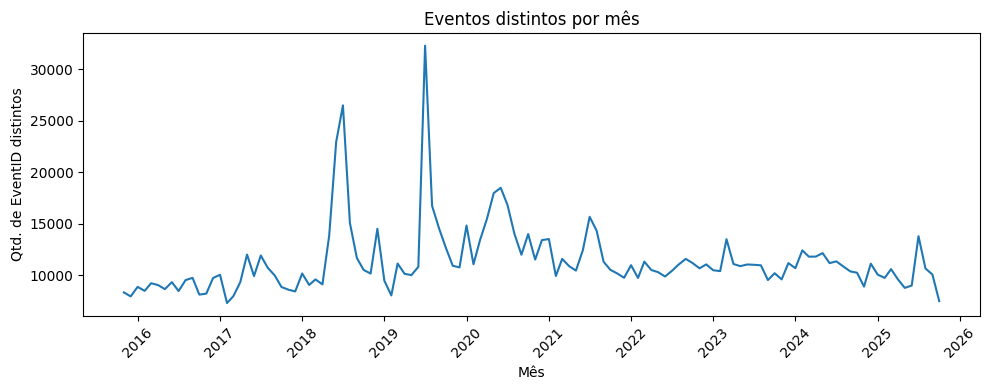

In [5]:
# Quantidade de Eventos por mês no mundo inteiro
qtt_events_per_month = (
    earthquake_data
        .groupby(earthquake_data['Time'].dt.to_period("M"))['#EventID']
        .nunique()
)
qtt_events_per_month.index = qtt_events_per_month.index.to_timestamp()

plt.figure(figsize=(10,4))
plt.plot(
    qtt_events_per_month.index,
    qtt_events_per_month.values
)
plt.xlabel("Mês")
plt.ylabel("Qtd. de EventID distintos")
plt.title("Eventos distintos por mês")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

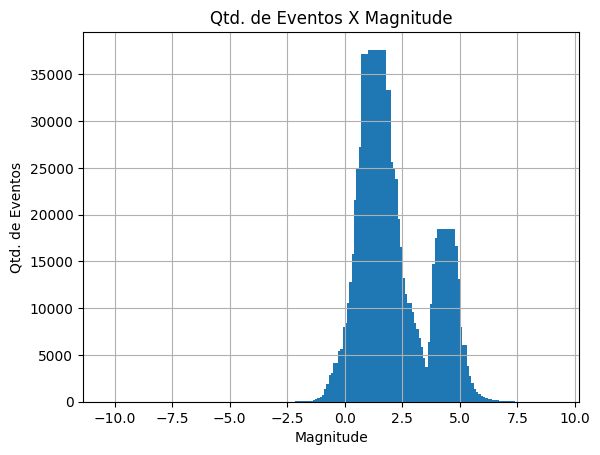

In [6]:
# Quantidade de Eventos X Magnitude

qtt_events_per_magnitude = (
    earthquake_data
        .groupby(earthquake_data['Magnitude'])['#EventID']
        .nunique()
        .sort_index()
)

plt.bar(
    qtt_events_per_magnitude.index,
    qtt_events_per_magnitude.values
)
plt.xlabel("Magnitude")
plt.ylabel("Qtd. de Eventos")
plt.title("Qtd. de Eventos X Magnitude")
plt.grid(True)
plt.show()


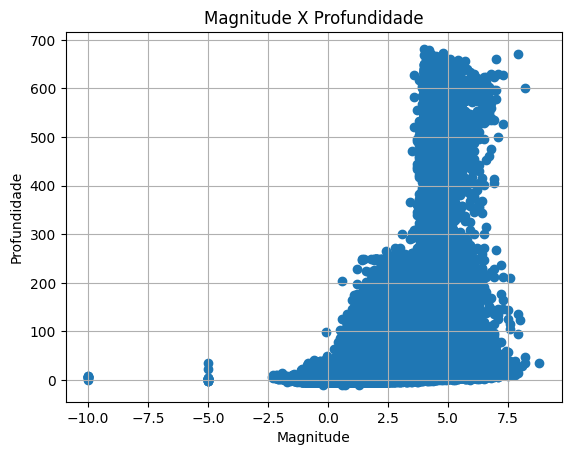

In [7]:
# Magnitude X Profundidade

df_depth_mag = earthquake_data.dropna(subset=['Depth/km'])

plt.scatter(
    df_depth_mag['Magnitude'].astype(float),
    df_depth_mag['Depth/km'].astype(float)
)
plt.ylabel("Profundidade")
plt.xlabel("Magnitude")
plt.title("Magnitude X Profundidade")
plt.grid(True)
plt.show()


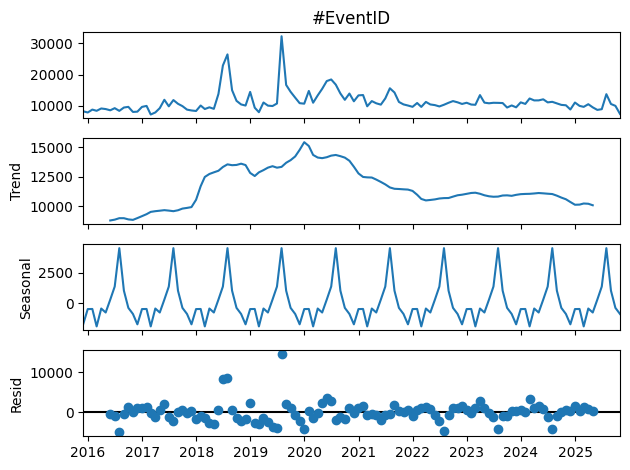

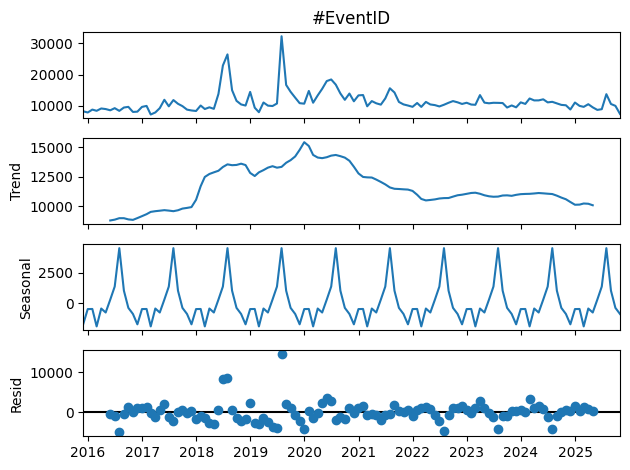

In [8]:
#decomposição estatística (tendencia + sazonalidade + ruído)
from statsmodels.tsa.seasonal import seasonal_decompose

ts = earthquake_data.resample("ME", on="Time")["#EventID"].nunique()
decompose = seasonal_decompose(ts, model='addtive', period=12)
decompose.plot()

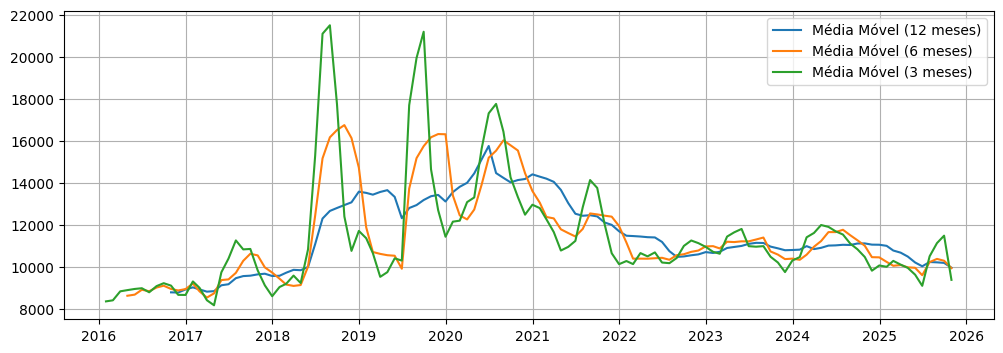

In [9]:
# Apresentação de Média Móvel

moving_avg_12 = ts.rolling(window=12).mean()
moving_avg_6 = ts.rolling(window=6).mean()
moving_avg_3 = ts.rolling(window=3).mean()
plt.figure(figsize=(12,4))
plt.plot(moving_avg_12, label="Média Móvel (12 meses)")
plt.plot(moving_avg_6, label="Média Móvel (6 meses)")
plt.plot(moving_avg_3, label="Média Móvel (3 meses)")
plt.legend()
plt.grid(True)
plt.show()

<Figure size 1200x500 with 0 Axes>

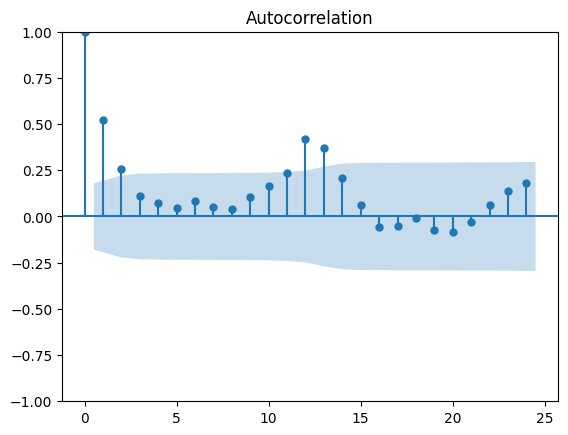

In [10]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.figure(figsize=(12,5))
plot_acf(ts, lags=24)
plt.show()

# tem autocorrelação significativa mês-a-mês
# apresenta sazonalidade anual clara
# não apresenta tendência forte no ACF

In [11]:
from statsmodels.tsa.stattools import adfuller
# Teste de Estacionaridade
print("============== Sem Diferenciação ============")
result = adfuller(ts.dropna())
print(f"Estatística ADF: {result[0]}")
print(f"p-value: {result[1]}")
if(result[1] < .05):
    print("A série é estacionária!")
else:
    print("A série não é estacionária!")
print("============== Com Diferenciação ============")
result = adfuller(ts.diff().dropna())
print(f"Estatística ADF: {result[0]}")
print(f"p-value: {result[1]}")
if(result[1] < .05):
    print("A série é estacionária!")
else:
    print("A série não é estacionária!")

============== Sem Diferenciação ============
Estatística ADF: -6.006005921389999
p-value: 1.61495761053971e-07
A série é estacionária!
============== Com Diferenciação ============
Estatística ADF: -7.633632365456677
p-value: 1.978662046026692e-11
A série é estacionária!


120


/home/chris/Faculdade_Python_Analise_Series_Temporais/.wsl_venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/home/chris/Faculdade_Python_Analise_Series_Temporais/.wsl_venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                           #EventID   No. Observations:                   94
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -645.659
Date:                            Sun, 23 Nov 2025   AIC                           1301.318
Time:                                    18:11:27   BIC                           1312.342
Sample:                                11-30-2015   HQIC                          1305.680
                                     - 08-31-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3633      0.221      1.642      0.101      -0.070       0.797
ma.L1         -0.9178      0.187   

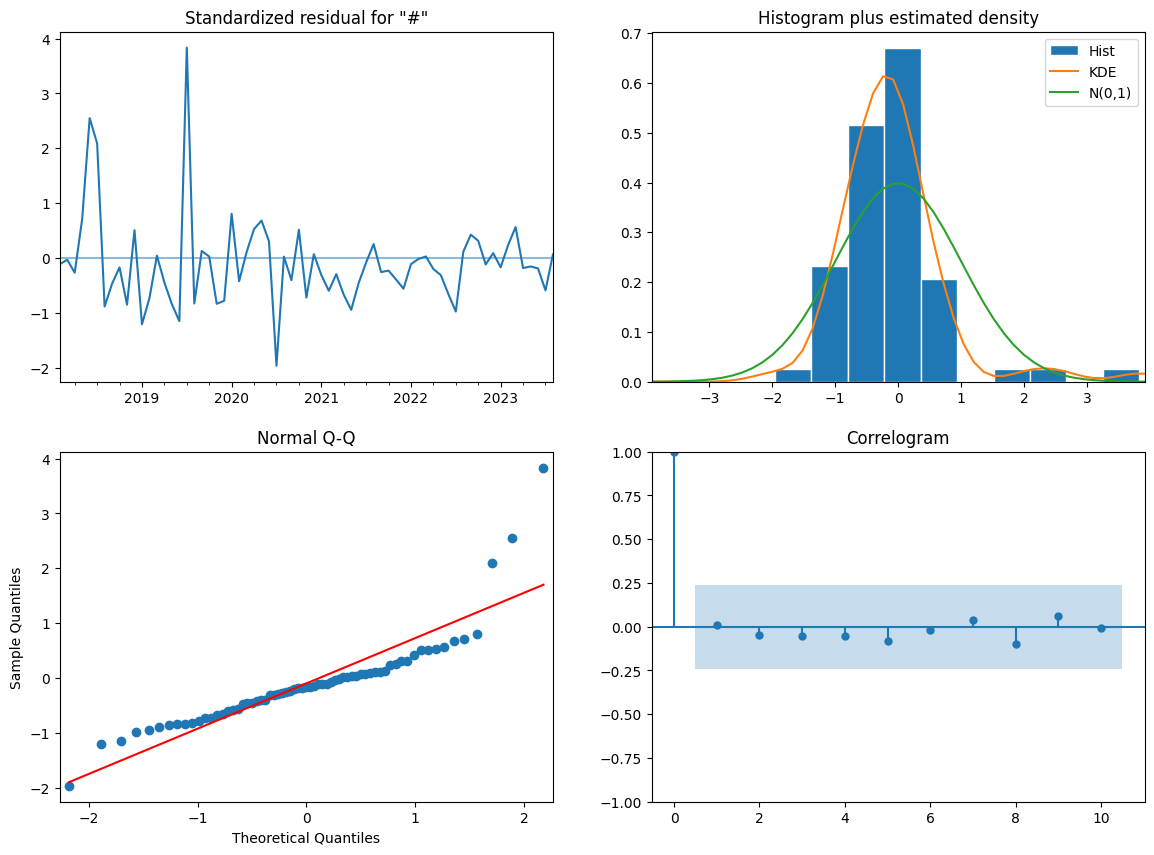

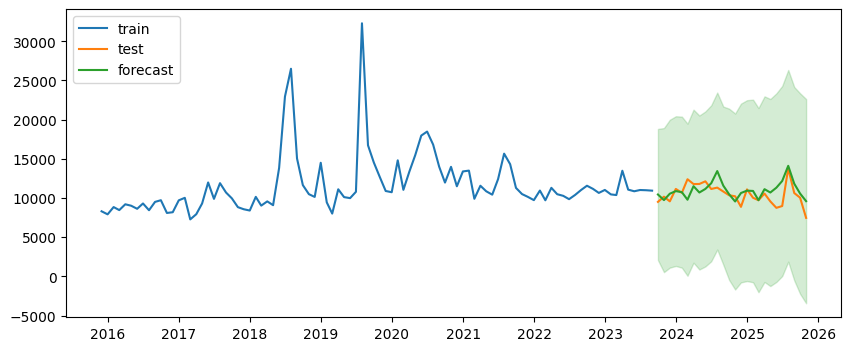

MAE: 1019.4208354623238
RMSE: 1328.0407071192503
9.721518226106182 12.664614544017617


In [12]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math
print(len(ts))
# Modelagem Preditiva SARIMA

train_end = -26
train = ts.iloc[:train_end]
test = ts.iloc[train_end:]

s=12 # padrão de sazonalidade
p,d,q = 1,1,1
P,D,Q = 1,1,1
model = SARIMAX(train, order=(p,d,q), seasonal_order=(P,D,Q,s), enforce_invertibility=False, enforce_stationarity=False)
res = model.fit(disp=False)
print(res.summary())
res.plot_diagnostics(figsize=(14, 10))
plt.show()

n_forecast = len(test)
pred = res.get_forecast(steps=n_forecast)
pred_mean = pred.predicted_mean
pred_ci = pred.conf_int()

plt.figure(figsize=(10,4))
plt.plot(train.index, train, label='train')
plt.plot(test.index, test, label='test', color='C1')
plt.plot(pred_mean.index, pred_mean, label='forecast', color='C2')
plt.fill_between(pred_ci.index, pred_ci.iloc[:,0], pred_ci.iloc[:,1], color='C2', alpha=0.2)
plt.legend(); plt.show()

mae = mean_absolute_error(test, pred_mean)
rmse = math.sqrt(mean_squared_error(test, pred_mean))
print("MAE:", mae)
print("RMSE:", rmse)

mae_percent = mae / test.mean() * 100
rmse_percent = rmse / test.mean() * 100
print(mae_percent, rmse_percent)


In [ ]:
from redisbloom.client import Client as RedisBloom
rb = RedisBloom(host='localhost', port=6379, password=None)

# ['#EventID', 'Time', 'Latitude', 'Longitude', 'Depth/km', 'Author',
#        'Catalog', 'Contributor', 'ContributorID', 'MagType', 'Magnitude',
#        'MagAuthor', 'EventLocationName']

rb.delete("events")
rb.bfCreate("events",0.01, 10000000)
for _,row in earthquake_data.iterrows():
    Magnitude = row['Magnitude']
    Depth_km = row['Depth/km']
    location = row['EventLocationName']
    key = str((Magnitude, Depth_km, location))
    rb.bfAdd("events", key)
    

(4.3, '10', 'west of Macquarie Island')
(4.3, '47.3', '21 km SW of Ovalle, Chile')
(4.2, '10', '45 km N of Likisá, Timor Leste')
(0.24, '7.72', '13km SE of Anza, CA')
(4.2, '10.42', '22 km WNW of Ejido, Venezuela')
(0.1, '2.6', '21 km ESE of Hawthorne, Nevada')
(4.0, '12.94', '16 km WNW of Ejido, Venezuela')
(3.6, '4.734', '9 km NE of Wakita, Oklahoma')
(0.76, '8.17', '13km SE of Anza, CA')
(1.47, '8.02', '13km SE of Anza, CA')
(1.91, '8.22', '13km SE of Anza, CA')
(1.9, '48.7', '1 km N of Nikolaevsk, Alaska')
(1.5, '4.8', '41 km SW of Manley Hot Springs, Alaska')
(4.2, '35.16', '85 km SSW of Puerto El Triunfo, El Salvador')
(0.4, '1.3', '64 km WNW of Beluga, Alaska')
(0.1, '2.18', '9 km WNW of Cobb, California')
(0.36, '1.91', '4 km SW of Cobb, California')
(5.2, '37.1', '126 km NW of Ternate, Indonesia')
(0.8, '1', '43 km SW of Manley Hot Springs, Alaska')
(0.5, '8.8', '34 km N of Benton, California')
(0.46, '2.15', '10 km W of Cobb, California')
(1.7, '6.8', '78 km NW of Yakutat, Al

KeyboardInterrupt: 

In [ ]:
data_exists = rb.bfExists("events","(0.24, '7.72', '13km SE of Anza, CA')")
print(data_exists)

(0.8, '4.6', '76 km WNW of Tyonek, Alaska')
1


In [5]:
import redis
import pandas as pd
from datasketch import MinHash
import hashlib
import pygeohash as pgh
import json

NUM_PERM = 128          # tamanho assinatura MinHash
BANDS = 32              # número de bandas
ROWS = NUM_PERM // BANDS  # hashes por banda
SHINGLE_SIZE = 3
PREFIX = "minhash_lsh"

r = redis.Redis(host="localhost", port=6379, decode_responses=True)

def lsh_clear(redis_conn):
    pipe = redis_conn.pipeline()
    for key in redis_conn.scan_iter(f"{PREFIX}:*"):
        pipe.delete(key)
    pipe.execute()

def lsh_insert(redis_conn, doc_id, minhash):
    hashvalues = [int(h) for h in minhash.hashvalues]
    redis_conn.set(f"{PREFIX}:signature:{doc_id}", json.dumps(hashvalues))
    for b in range(BANDS):
        start = b * ROWS
        end = start + ROWS
        band_hash = hashlib.sha1(str(hashvalues[start:end]).encode()).hexdigest()
        redis_key = f"{PREFIX}:band:{b}:{band_hash}"
        redis_conn.sadd(redis_key, doc_id)

def lsh_query(redis_conn, minhash):
    # Converte hashvalues para int
    hashvalues = [int(h) for h in minhash.hashvalues]

    candidates = set()

    for b in range(BANDS):
        start = b * ROWS
        end = start + ROWS

        band_hash = hashlib.sha1(str(hashvalues[start:end]).encode()).hexdigest()
        redis_key = f"{PREFIX}:band:{b}:{band_hash}"

        ids = redis_conn.smembers(redis_key)
        candidates.update(ids)

    return list(candidates)


def generate_minhash_signature(text, num_perm=NUM_PERM, shingle_size=SHINGLE_SIZE):
    # Gera a assinatura MinHash para uma string de texto.
    text = str(text).lower()
    shingles = set()
    for i in range(len(text) - shingle_size + 1):
        shingles.add(text[i:i + shingle_size].encode('utf8'))
    m = MinHash(num_perm=num_perm)
    for shingle in shingles:
        m.update(shingle)
    return m

lsh_clear(r)
minhash_results = {}

lsh_data = earthquake_data.dropna(subset=['Latitude', 'Longitude'])

for i,row in lsh_data.iterrows():
    Magnitude = row['Magnitude']
    Depth_km = row['Depth/km']
    long,lat = float(row['Longitude']),float(row['Latitude'])
    id_loc = pgh.encode(lat,long, precision=5)
    key = str((Magnitude, Depth_km, id_loc))
    m = generate_minhash_signature(key)
    if(i < 3):
        minhash_results[i] = m
        print(f"{i} | {key}")
    lsh_insert(r,str(i),m)


0 | (4.3, '10', 'pq0df')
1 | (4.3, '47.3', '66t1r')
2 | (4.2, '10', 'qy916')


KeyboardInterrupt: 

In [6]:
result = lsh_query(r, minhash_results[0])
print(result)

['55714', '108232', '89348', '117022', '70075', '51671', '42756', '45165', '50334', '1576', '48900', '33185', '28170', '82664', '69105', '18368', '102182', '89203', '7732', '5067', '8083', '96227', '53339', '15675', '29678', '12049', '88619', '84090', '112073', '49450', '115127', '117825', '53405', '35741', '8447', '24957', '115442', '8178', '82962', '49644', '41235', '83525', '120642', '114545', '59363', '2315', '11466', '94697', '4015', '13649', '103723', '76162', '84130', '64214', '95967', '26760', '84133', '17338', '120115', '14849', '115373', '61875', '45798', '33000', '91572', '3103', '17999', '83550', '100747', '50921', '12893', '15282', '117496', '87952', '117518', '14455', '85238', '93039', '72090', '109512', '89195', '87140', '117139', '95260', '105598', '112109', '69590', '64430', '106843', '44863', '101858', '109481', '73209', '77172', '14971', '104128', '104066', '36139', '3390', '93930', '18053', '117714', '53417', '120388', '35167', '34952', '111534', '70034', '72353', '